In [36]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from warnings import filterwarnings
filterwarnings("ignore")

In [58]:
titanic_df = pd.read_csv("train.xls")
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [59]:
print(f"Len DF: {titanic_df.__len__()}")
print(f"====================")
print(f"Info: \n{titanic_df.isna().sum()}")

Len DF: 891
Info: 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


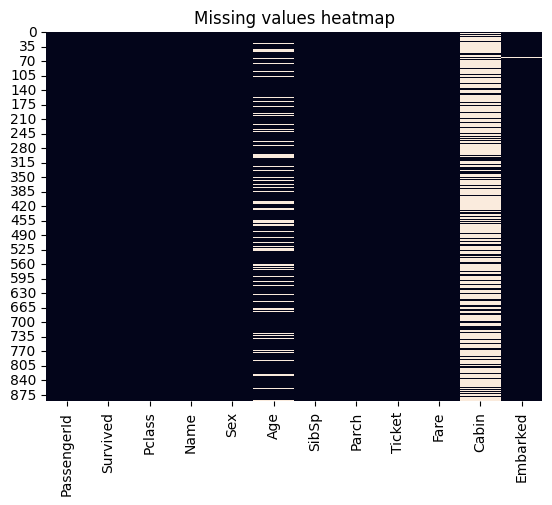

In [60]:
sns.heatmap(titanic_df.isnull(), cbar = False)
plt.title("Missing values heatmap")
plt.show()

In [40]:
# Cabin имеет слишком много пропусков, легче избавиться от него
titanic_df = titanic_df.drop("Cabin", axis=1)

In [41]:
# Обработка чистого DataFrame'а
clean_df = titanic_df.copy()
clean_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [42]:
# 2 пустых записи Embarked тоже легче удалить
clean_df = clean_df.dropna(subset=["Embarked"])
clean_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
dtype: int64

In [43]:
# Заполняю пропуски средним возрастом мужчин и женщин 
mean_male_age = round(clean_df.query("Sex == 'male' and not Age.isna()")["Age"].mean(), 2)
mean_female_age = round(clean_df.query("Sex == 'female' and not Age.isna()")["Age"].mean(), 2)
print(f"Mean age: \nmale: {mean_male_age} \nfemale: {mean_female_age}")
clean_df.loc[(clean_df["Age"].isna()) & (clean_df["Sex"] == 'male')] = clean_df.loc[(clean_df["Age"].isna()) & (clean_df["Sex"] == 'male')].fillna(mean_male_age)
clean_df.loc[(clean_df["Age"].isna()) & (clean_df["Sex"] == 'female')] = clean_df.loc[(clean_df["Age"].isna()) & (clean_df["Sex"] == 'female')].fillna(mean_female_age)
clean_df.isna().sum()

Mean age: 
male: 30.73 
female: 27.75


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [44]:
clean_df.describe().round(2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,889.0,889.00,889.00,889.00,889.00,889.00,889.00
mean,446.0,0.38,2.31,29.68,0.52,0.38,32.10
std,257.0,0.49,0.83,12.98,1.10,0.81,49.70
min,1.0,0.00,1.00,0.42,0.00,0.00,0.00
25%,224.0,0.00,2.00,22.00,0.00,0.00,7.90
50%,446.0,0.00,3.00,30.00,0.00,0.00,14.45
75%,668.0,1.00,3.00,35.00,1.00,0.00,31.00
max,891.0,1.00,3.00,80.00,8.00,6.00,512.33


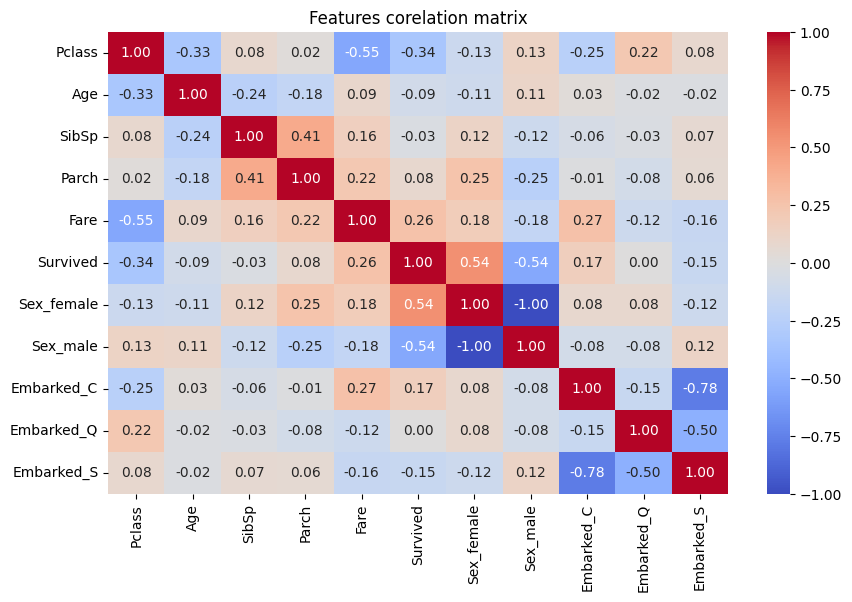

In [45]:
corr_matrix = pd.get_dummies(clean_df[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Survived"]]).corr().round(2)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, fmt='.2f', cbar=True, cmap='coolwarm',  annot=True,)
plt.title("Features corelation matrix")
plt.show()

In [46]:
X = pd.get_dummies(clean_df[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]])
y = clean_df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
len(X_train), len(X_test)

(444, 445)

# Подбор лучших параметров

In [29]:
rf_clf = RandomForestClassifier()
params = {
    "n_estimators": [50, 75, 100, 125, 150, 175, 200], # колл-во решающих деревьев
    "criterion": ["entropy", "gini"],                  # метод понижения information-gane 
    "max_depth": range(3, 12),                         # максимальная глубина дерева
    "min_samples_split": [50, 60, 70, 80, 90, 100],    # минимальное число вариаций, при котором можно продолжать дереву расти в глубину 
    "min_samples_leaf": [5, 6, 7, 8, 9, 10]            # минимальное количество образцов, необходимое для нахождения в листовом узле каждого дерева
}

In [30]:
# Перебор долгий (50+ минут), не советую запускать для проверки
# Лучшие параметры {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 50, 'n_estimators': 150}
# Можно запустить RandomizedSearchCV, если очень хочется проверить, но не хочется ждать :) но результат будет другой
gs_cv = GridSearchCV( 
    rf_clf,
    params,
    cv=5
)
gs_cv.fit(X_train, y_train)
print(f"Best params: {gs_cv.best_params_}")

Best params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 50, 'n_estimators': 150}


# Метрики

In [53]:
best_rf_clf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=150,
        criterion="entropy",
        max_depth=10,
        min_samples_split=50,
        min_samples_leaf=5
        )
)
best_rf_clf.fit(X_train, y_train)
y_pred = best_rf_clf.predict(X_test)
print(f"Train score: {round(best_rf_clf.score(X_train, y_train), 2)}%")
print(f"Test score:  {round(best_rf_clf.score(X_test, y_test), 2)}%")

Train score: 0.83%
Test score:  0.81%


In [54]:
cross_val = cross_val_score(best_rf_clf, X_test, y_test, cv=5).mean()
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
metric_df = pd.DataFrame({
    "Cross val": [round(cross_val, 2)],
    "Precision": [round(precision, 2)],
    "Recall": [round(recall, 2)],
    "F1": [round(f1, 2)],
}).T
metric_df.reset_index(inplace=True)
metric_df.columns = ["Metrics", "Score"]
metric_df.head()

,Metrics,Score
0,Cross val,0.77
1,Precision,0.77
2,Recall,0.71
3,F1,0.74


In [ ]:
feature_important = pd.DataFrame({"Feature": best_rf_clf.feature_importances_}, index=list(X)).T
feature_important["Sex"] = feature_important["Sex_male"] + feature_important["Sex_female"]
feature_important["Embarked"] = feature_important["Embarked_C"] + feature_important["Embarked_Q"] + feature_important["Embarked_S"]
feature_important = feature_important[["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex", "Embarked"]].T
feature_important = feature_important.sort_values(ascending=False, by=["Feature"])
feature_important.reset_index(inplace=True)
feature_important.columns = ["Feature", "Important %"]
feature_important.head(10).round(2)

,Feature,Important %
0,Sex,0.52
1,Pclass,0.14
2,Fare,0.13
3,Age,0.11
4,Embarked,0.05
5,SibSp,0.03
6,Parch,0.02


# Выводы
TODO